<a href="https://colab.research.google.com/github/alimaskina/TinkLabTask/blob/main/TinkLabNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Level 1

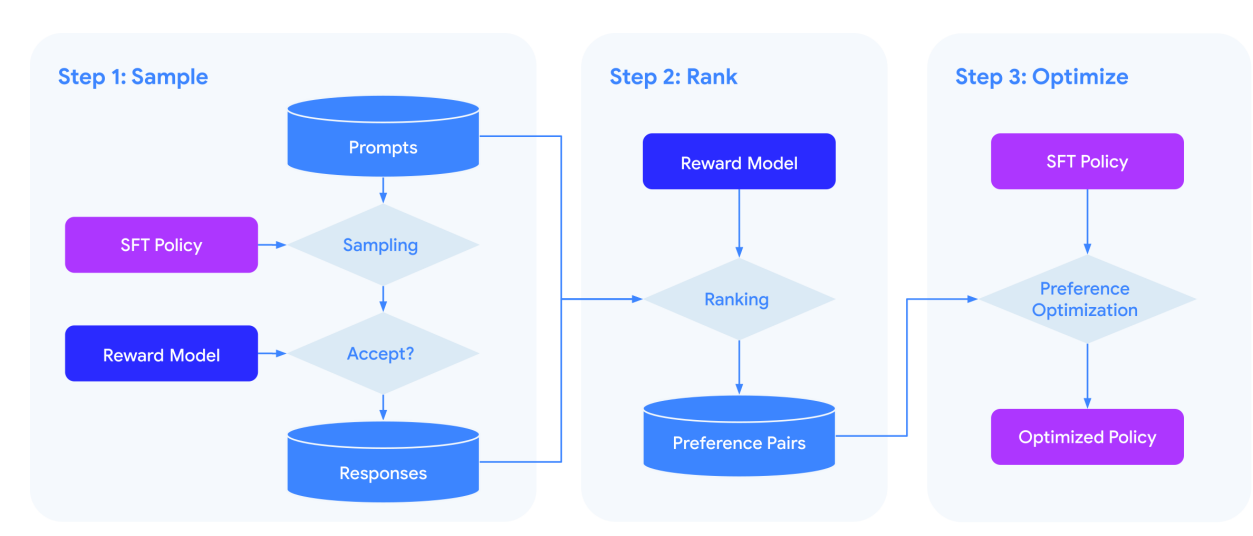

### Sample and Rank

На основе промптов сгенерируем ответы, разделим их на положительные и отрицательные и составим тренировочный датасет из троек (prompt, winner, loser).  
1.   Промпты генерировались chatgpt и подобраны как можно более нейтральными, чтобы к каждому можно было придумать ответы разной тональности.
2.   Для читабельности логиты преобразуются в вероятности.
3.   Проанализировав ранги, я заметила, что итоговая вероятность "положительности" рецензии близка к крайним значениям: 0 и 1, т.е. например две положительных рецензии сравнивать между собой не очень полезно. Поэтому для обучения используются пары winer - positive, loser - negative.
4.   top_k=25 и temperature=0.9 отличаются от тех, что были в статье
5.   Сгенерированные данные приходится сохранять локально, потому что среда очень нестабильна.

In [1]:
!pip install transformers
!pip install torch

In [2]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch

In [18]:
# Проверяем доступность GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU доступен.")
else:
    device = torch.device("cpu")
    print("GPU не доступен, используем CPU.")

GPU доступен.


In [19]:
# Загрузка моделей
sft_model = GPT2LMHeadModel.from_pretrained("lvwerra/gpt2-imdb")
sft_tokenizer = GPT2Tokenizer.from_pretrained("lvwerra/gpt2-imdb")

rank_model = DistilBertForSequenceClassification.from_pretrained("lvwerra/distilbert-imdb")
rank_tokenizer = DistilBertTokenizer.from_pretrained("lvwerra/distilbert-imdb")

In [5]:
# Функция для генерации ответов
def generate_response(prompt, num):
    inputs = sft_tokenizer(prompt, return_tensors='pt', truncation=True, max_length=30)
    outputs = sft_model.generate(**inputs, max_length=30, num_return_sequences=num, do_sample=True, top_k=25, temperature=0.9)
    return [sft_tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

# Функция для ранжирования ответов
def rank_responses(responses):
    chosen = []
    rejected = []
    for response in responses:
        inputs = rank_tokenizer.encode(response, return_tensors='pt')
        outputs = rank_model(inputs)
        prediction = torch.softmax(outputs.logits[0], dim=0)[1].item()
        if prediction > 0.5:
            chosen.append(response)
        else:
            rejected.append(response)
    return chosen, rejected

In [ ]:
prompts = [
    "In the movie world,",
    "Watching a classic film,",
    "The new TV series,",
    "Award-winning performance,",
    "The cinema experience,",
    "On the red carpet,",
    "Sci-fi movies often explore,",
    "Romantic comedies usually feature,",
    "Documentaries about nature,",
    "Horror film trends,",
    "Animation versus live-action,",
    "Behind the scenes of filmmaking,",
    "Celebrity interviews reveal,",
    "Film festival highlights,",
    "The evolution of superhero movies,",
    "Classic versus modern horror,",
    "In the director's chair,",
    "Musical scores in cinema,",
    "Film adaptations of books,",
    "Biopics and historical accuracy,",
    "The art of movie editing,",
    "The role of a film producer,",
    "Cult classics in film history,",
    "The future of streaming services,",
    "Blockbuster movie phenomena,",
    "Independent film scene,",
    "Comedy in modern cinema,",
    "The impact of film critics,",
    "Virtual reality in movie experiences,",
    "The portrayal of villains in movies,",
    "The film's story begins when",
    "In this scene, we see",
    "The character's journey starts with",
    "Set in a world where",
    "The movie depicts a scenario in which",
    "In the heart of the city, there is",
    "During a typical day, the main character",
    "The narrative unfolds with a scene showing",
    "Exploring the themes of",
    "The plot takes a turn when",
    "Centered around the life of",
    "In the midst of a conflict, the protagonist",
    "The setting of the story is characterized by",
    "As the story progresses, we discover",
    "Caught between different worlds, the character",
    "The tale weaves through the events of",
    "In an unexpected twist, the film",
    "Juxtaposing the past and present, the story",
    "The climax of the movie occurs during",
    "The narrative explores the relationship between"
]


# Генерация и ранжирование данных
dpo_dataset_dict = {"prompt": [], "chosen": [], "rejected": []}
for prompt in prompts:
    responses = generate_response(prompt, 30)
    chosen, rejected = rank_responses(responses)
    for pos in chosen:
      for neg in rejected:
        dpo_dataset_dict['prompt'].append(prompt)
        dpo_dataset_dict['chosen'].append(pos)
        dpo_dataset_dict['rejected'].append(neg)



In [6]:
import json
# Сохранение данных в файл JSON
with open('generated_data.json', 'w') as json_file:
    json.dump(dpo_dataset_dict, json_file, indent=4)

print("Data saved to 'generated_data.json'")

Data saved to 'generated_data.json'


In [7]:
len(dpo_dataset_dict['prompt'])

6492

### Optimize

Дообучаем модель с разными лоссами на подготовденном ранее датасете.

Данные делятся на обучающую, валидационную и тестовую выборки. На тестовой выборке впоследствии и проводятся оценки средней награды и энтропии.



In [6]:
!pip install trl

In [7]:
! pip install -U accelerate
! pip install -U transformers

In [8]:
import accelerate
accelerate.__version__

'0.25.0'

In [9]:
from sklearn.model_selection import train_test_split
import json

# Чтение сохраненных данных
with open('generated_data.json', 'r') as file:
    dpo_dataset_dict = json.load(file)

# Разделение на обучающую, валидационную и тестовую выборки
train_dataset, temp_dataset = train_test_split(
    list(zip(dpo_dataset_dict["prompt"], dpo_dataset_dict["chosen"], dpo_dataset_dict["rejected"])),
    test_size=0.2,
    random_state=42
)

valid_dataset, test_dataset = train_test_split(
    temp_dataset,
    test_size=0.5,
    random_state=42
)

# Функция для преобразования данных обратно в словарь
def convert_to_dict(dataset):
    return {
        "prompt": [item[0] for item in dataset],
        "chosen": [item[1] for item in dataset],
        "rejected": [item[2] for item in dataset]
    }

# Преобразование выборок обратно в словари
train_dataset_dict = convert_to_dict(train_dataset)
valid_dataset_dict = convert_to_dict(valid_dataset)
test_dataset_dict = convert_to_dict(test_dataset)

In [10]:
from transformers import TrainingArguments
from trl import DPOTrainer
from datasets import Dataset

# Создание объекта TrainingArguments для настройки обучения
training_args_sigmoid = TrainingArguments(
    output_dir="./output_sigmoid",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    save_total_limit=1
)

# Инициализация DPOTrainer
sft_tokenizer.pad_token_id = 4
dpo_trainer_sigmoid = DPOTrainer(
    sft_model,
    args=training_args_sigmoid,
    beta=0.1,
    train_dataset=Dataset.from_dict(train_dataset_dict),
    eval_dataset=Dataset.from_dict(valid_dataset_dict),
    tokenizer=sft_tokenizer,
    loss_type="sigmoid"
)

# Обучение
dpo_trainer_sigmoid.train()

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/dpo_trainer.py:255: UserWarning: When using DPODataCollatorWithPadding, you should set `max_length` in the DPOTrainer's init it will be set to `512` by default, but you should do it yourself in the future.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/dpo_trainer.py:262: UserWarning: When using DPODataCollatorWithPadding, you should set `max_prompt_length` in the DPOTrainer's init it will be set to `128` by default, but you should do it yourself in the future.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/dpo_trainer.py:291: UserWarning: When using DPODataCollatorWithPadding, you should set `remove_unused_columns=False` in your TrainingArguments we have set it for you, but you should do 

Epoch,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/rejected,Logps/chosen,Logits/rejected,Logits/chosen
1,0.039800,0.000052,-4.885152,-19.021549,1.000000,14.136397,-280.832520,-139.594101,-42.510838,-36.140339
2,0.000000,0.000020,-4.895311,-19.479637,1.000000,14.584327,-285.413422,-139.695679,-43.806244,-37.342278
3,0.000000,0.000016,-4.938519,-19.662399,1.000000,14.723880,-287.241028,-140.127762,-44.274868,-37.827793


TrainOutput(global_step=1932, training_loss=0.010303859456247549, metrics={'train_runtime': 751.3069, 'train_samples_per_second': 20.572, 'train_steps_per_second': 2.572, 'total_flos': 0.0, 'train_loss': 0.010303859456247549, 'epoch': 3.0})

In [12]:
model_path = "output_sigmoid/checkpoint-1500"
model_sigmoid = GPT2LMHeadModel.from_pretrained(model_path)
tokenizer_sigmoid = GPT2Tokenizer.from_pretrained(model_path)

In [ ]:
!zip -r sigmoid.zip /content/output_sigmoid/checkpoint-1500/

In [14]:
# Генерация текстов для оценки качества на тестововй выборке
def generate_texts(model, tokenizer, prompts, num_generate=1):
    generated_texts = []
    for prompt in prompts:
        input_ids = tokenizer.encode(prompt, return_tensors='pt')
        output_sequences = model.generate(input_ids=input_ids, max_length=30, num_return_sequences=num_generate)
        for output in output_sequences:
            text = tokenizer.decode(output, skip_special_tokens=True)
            generated_texts.append(text)
    return generated_texts

In [15]:
from scipy.stats import entropy
from collections import defaultdict

def token_entropy(generations, tokenizer):
    stats = defaultdict(int)
    num_tokens = 0
    for example in generations:
        tokens = tokenizer.encode(example)
    for t in tokens:
        if t == tokenizer.pad_token_id:
            continue
        stats[t] += 1
        num_tokens += 1
    for k in stats.keys():
        stats[k] /= num_tokens
    return entropy(list(stats.values()))

In [16]:
def calculate_average_reward(generations, classification_model, classification_tokenizer):
    total_reward = 0
    num_responses = 0

    for generation in generations:
        # Оценка ответа моделью классификации
        classification_inputs = classification_tokenizer(generation, return_tensors="pt", truncation=True, max_length=512)
        classification_outputs = classification_model(**classification_inputs)
        logits = classification_outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        positive_prob = probabilities[0][1].item()

        # Обновление общего реварда
        total_reward += positive_prob
        num_responses += 1

    # Вычисление среднего реварда
    average_reward = total_reward / num_responses
    return average_reward

In [ ]:
# Генерируем ответы исходной модели
sft_generations = generate_texts(sft_model, sft_tokenizer, test_dataset_dict['prompt'])

In [21]:
import json
# Сохранение данных в файл JSON
with open('sft_generated.json', 'w') as json_file:
    json.dump(sft_generations, json_file, indent=4)

print("Data saved to 'sft_generated.json'")

Data saved to 'sft_generated.json'


In [26]:
# Вычисляем среднюю награду исходной модели
sft_reward = calculate_average_reward(sft_generations, rank_model, rank_tokenizer)

In [27]:
# Вычисляем энтропию исходной модели
sft_entropy = token_entropy(sft_generations, sft_tokenizer)

In [28]:
sft_reward, sft_entropy

(0.7842618085682219, 2.6156305770275505)

In [ ]:
# Генерируем ответы дообученной модели с sigmoid-loss
sigmoid_generations = generate_texts(model_sigmoid, tokenizer_sigmoid, test_dataset_dict['prompt'])

In [30]:
import json
# Сохранение данных в файл JSON
with open('sigmoid_generated.json', 'w') as json_file:
    json.dump(sigmoid_generations, json_file, indent=4)

print("Data saved to 'sigmoid_generated.json'")

Data saved to 'sigmoid_generated.json'


In [31]:
# Вычисляем среднюю награду модели с sigmoid-loss
sigmoid_reward = calculate_average_reward(sigmoid_generations, rank_model, rank_tokenizer)

In [32]:
# Вычисляем энтропию модели с sigmoid-loss
sigmoid_entropy = token_entropy(sigmoid_generations, sft_tokenizer)

In [33]:
sigmoid_reward, sigmoid_entropy

(0.9598270170448362, 2.967867468534036)

In [34]:
# Для hinge лосса

# Создание объекта TrainingArguments для настройки обучения
training_args_hinge = TrainingArguments(
    output_dir="./output_hinge",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    save_total_limit=1
)

# Инициализация DPOTrainer
sft_tokenizer.pad_token_id = 4
dpo_trainer_hinge = DPOTrainer(
    sft_model,
    args=training_args_hinge,
    beta=0.1,
    train_dataset=Dataset.from_dict(train_dataset_dict),
    eval_dataset=Dataset.from_dict(valid_dataset_dict),
    tokenizer=sft_tokenizer,
    loss_type = 'hinge'
)


# Обучение
dpo_trainer_hinge.train()

/usr/local/lib/python3.10/dist-packages/trl/trainer/dpo_trainer.py:255: UserWarning: When using DPODataCollatorWithPadding, you should set `max_length` in the DPOTrainer's init it will be set to `512` by default, but you should do it yourself in the future.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/dpo_trainer.py:262: UserWarning: When using DPODataCollatorWithPadding, you should set `max_prompt_length` in the DPOTrainer's init it will be set to `128` by default, but you should do it yourself in the future.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/dpo_trainer.py:291: UserWarning: When using DPODataCollatorWithPadding, you should set `remove_unused_columns=False` in your TrainingArguments we have set it for you, but you should do it yourself in the future.
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Epoch,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/rejected,Logps/chosen,Logits/rejected,Logits/chosen
1,0.055800,0.003338,-1.248551,-6.486584,1.000000,5.238033,-155.482880,-103.228104,-34.282829,-33.114174
2,0.001600,0.002071,-1.062104,-6.686878,1.000000,5.624775,-157.485825,-101.363632,-27.204948,-26.332848
3,0.000300,0.001418,-0.935068,-6.762644,1.000000,5.827576,-158.243484,-100.093269,-30.410578,-29.722506


TrainOutput(global_step=1932, training_loss=0.014938824688610823, metrics={'train_runtime': 671.1416, 'train_samples_per_second': 23.029, 'train_steps_per_second': 2.879, 'total_flos': 0.0, 'train_loss': 0.014938824688610823, 'epoch': 3.0})

In [ ]:
!zip -r hinge.zip /content/output_hinge/checkpoint-1500/

In [35]:
model_path = "output_hinge/checkpoint-1500"
model_hinge = GPT2LMHeadModel.from_pretrained(model_path)
tokenizer_hinge = GPT2Tokenizer.from_pretrained(model_path)

In [ ]:
# Генерируем ответы дообученной модели с hinge-loss
hinge_generations = generate_texts(model_hinge, tokenizer_hinge, test_dataset_dict['prompt'])

In [38]:
import json
# Сохранение данных в файл JSON
with open('hinge_generated.json', 'w') as json_file:
    json.dump(hinge_generations, json_file, indent=4)

print("Data saved to 'hinge_generated.json'")

Data saved to 'hinge_generated.json'


In [39]:
# Вычисляем среднюю награду модели с hinge-loss
hinge_reward = calculate_average_reward(hinge_generations, rank_model, rank_tokenizer)

In [40]:
# Вычисляем энтропию модели с hinge-loss
hinge_entropy = token_entropy(hinge_generations, sft_tokenizer)

In [41]:
hinge_reward, hinge_entropy

(0.9703970021979753, 2.904216051704555)

## Вывод

Можно сделать следующие наблюдения:

1.   Оба лосса уже за первую эпоху очень приближаются к 0. Можно было бы говорить о переобучении, но так как на тестовой выборке среднее значение reward тоже довольно высоко, то скорее всего это нормально. Более вероятно, что у меня не так много данных в тренировочном датасете или где-то меняется распределение.
2.   Среднее значение награды существенно повысилось после обучения. Стоит заметить, что изначальнная модель тоже чаще генерировала положительные рецензии, но после обучения вероятность "положительности" возросла c 0.78 до 0.97 для hinge loss и до 0.96 для sigmoid loss. Т.е. калибровка помогла, и нет большой разницы между лоссами.  
3.   Энтропия неожидано повысилась после обучения! Я могу лишь предположить поему такое могло произойти:

*   Если модель изначально обучалась на смеси положительных, нейтральных и негативных текстов, ее словарный запас мог быть более ограничен или сосредоточен на общих словах, характерных для всех этих тонов. Специализация на положительных текстах могла ввести больше специфических для положительной речи слов и выражений, что привело к повышению энтропии.
*   Дообучение модели исключительно на положительных текстах изменяет распределение токенов, которые модель склонна генерировать. Это новое распределение может быть менее предсказуемым, чем предыдущее, что приводит к повышению энтропии.



# Level 2


В статьях для изучения представлена α-дивергенция. Для различных значений α проводятся эксперименты.   
Чтобы подменить функцию потерь в DPOTrainer я бы попробовала создать наследника этого класса и переопределить в нем части свзяанные с лоссом.

alpha_divergence_loss вычисляет α-дивергенцию между предсказаниями модели и целевыми распределениями.  
Args:
  predictions (torch.Tensor): Тензор предсказаний модели.  
  targets (torch.Tensor): Тензор целевых распределений.  
  alpha (float): Параметр α для α-дивергенции.  
  epsilon (float): Малое число для стабильности вычислений.  
  
Returns:
  torch.Tensor: Значение потерь α-дивергенции.

In [1]:
import torch

def alpha_divergence_loss(predictions, targets, alpha, epsilon=1e-6):
    # Добавление epsilon для численной стабильности
    predictions = torch.clamp(predictions, epsilon, 1.0)
    targets = torch.clamp(targets, epsilon, 1.0)

    # Вычисление α-дивергенции
    if alpha == 1:  # KL-дивергенция
        loss = torch.sum(targets * torch.log(targets / predictions))
    elif alpha == 0:  # Обратная KL-дивергенция
        loss = torch.sum(predictions * torch.log(predictions / targets))
    else:  # Обобщенная α-дивергенция
        loss = 1 / (alpha * (1 - alpha)) * (1 - torch.sum(targets ** alpha * predictions ** (1 - alpha)))

    return loss


In [ ]:
!pip install trl

In [ ]:
from transformers import TrainingArguments
from trl import DPOTrainer
from datasets import Dataset

class ModifiedDPOTrainer(DPOTrainer):
    def __init__(self, *args, alpha=0.5, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha

    # Переопределение метода для вычисления потерь с использованием α-дивергенции.
    def compute_loss(self, model, inputs):
        outputs = model(**inputs)
        predictions = outputs.logits
        targets = inputs["labels"]

        # Вызываем нашу функцию потерь α-дивергенции
        loss = alpha_divergence_loss(predictions, targets, self.alpha)
        return loss


In [ ]:
# Создание объекта TrainingArguments для настройки обучения
training_args_alpha = TrainingArguments(
    output_dir="./output_alpha",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    save_total_limit=1
)

# Инициализация DPOTrainer
sft_tokenizer.pad_token_id = 4
dpo_trainer_alpha = ModifiedDPOTrainer(
    sft_model,
    args=training_args_alpha,
    beta=0.1,
    train_dataset=Dataset.from_dict(train_dataset_dict),
    eval_dataset=Dataset.from_dict(valid_dataset_dict),
    tokenizer=sft_tokenizer,
    alpha = 1
)


# Обучение
dpo_trainer_alpha.train()

К сожалению, я не успеваю завершить эту часть задания.   
Но читать настоящие статьи и делать все это было очень интересно! Спасибо😀